# Figure 3.

Time average vertical profiles of (a, b) temperature ($T$, $K$) and (c,
d) water vapor ($q$, $kg~kg^{-1}$) at the sub-stellar point (solid) and
its antipode (dashed) in the (left column) Trappist-1e and (right
column) Proxima b simulations with the (blue) *MassFlux*, (orange)
*Adjust*, and (green) *NoCnvPm* set-up. Note the logarithmic scale of
the abscissa in (c) and (d).

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

Import the necessary libraries.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt

import numpy as np

In [3]:
from aeolus.calc import last_year_mean, spatial
from aeolus.coord_utils import UM_HGT
from aeolus.core import Run
from aeolus.region import Region
from aeolus.util import fmt_lonlat, subplot_label_generator

In [4]:
from commons import (
    GLM_MODEL_TIMESTEP,
    PLANET_ALIASES,
    RUN_ALIASES,
    output_name_prefix,
)
from global_run_diags import calc_derived_cubes
import mypaths
from plot_funcs import MARKER_KW, add_aux_yticks, add_custom_legend, use_style
from utils import tex2cf_units

Global stylesheet for figures.

In [5]:
use_style()

## Load data

Create a dictionary of `Run` objects with preprocessed data.

In [6]:
runs = {}
for planet in PLANET_ALIASES.keys():
    for run_key in RUN_ALIASES.keys():
        label = f"{planet}_{run_key}"

        fname = mypaths.sadir / label / "_processed" / f"{label}.nc"

        runs[label] = Run(
            files=fname,
            name=label,
            planet=planet,
            timestep=GLM_MODEL_TIMESTEP,
            processed=True,
        )

        # Calculate additional diagnostics
        runs[label].add_data(calc_derived_cubes)

## Plot the results

Select variables and set up metadata

In [7]:
vrbls2plot = {
    "temp": {
        "func": lambda cl: cl.extract_strict("air_temperature"),
        "tex_units": "$K$",
        "xlim": [170, 290],
        "xlabel": "Air temperature",
    },
    "shum": {
        "func": lambda cl: cl.extract_strict("specific_humidity"),
        "tex_units": "$kg$ $kg^{-1}$",
        "xlim": [1e-8, 1e-1],
        "scale": "log",
        "xlabel": "Specific humidity",
    },
}

Define region boundaries

In [8]:
ddeg = 1  # within +-1 degree, i.e. at the substellar/antistellar point
daynight = {
    "day": Region(-ddeg, ddeg, -ddeg, ddeg, "substellar_region"),
    "night": Region(-ddeg + 180, ddeg - 180, -ddeg, ddeg, "antistellar_region"),
}

Tick marks for the secondary y-axis

In [9]:
_hgt_ticks = np.array([0, 1, 2, 5, 10, 15, 40])

Line styles and font sizes

In [10]:
daynight_plt_kw = {"day": dict(linestyle="-"), "night": dict(linestyle="--")}

ttl_kw = dict(fontsize="small", pad=5, loc="left")

In [11]:
# Number of columns and rows
nrows = len(vrbls2plot)
ncols = len(PLANET_ALIASES)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9 * ncols, 6 * nrows),)

iletters = subplot_label_generator()

for (vrbl, vrbl_dict), axrow in zip(vrbls2plot.items(), axs):
    tex_units = vrbl_dict["tex_units"]
    cube_units = tex2cf_units(tex_units)
    for planet, ax in zip(PLANET_ALIASES.keys(), axrow):
        ax.set_title(f"({next(iletters)})", fontsize="small", loc="left")
        if ax.is_first_row():
            ax.set_title(PLANET_ALIASES[planet], fontsize="large", loc="center")
        ax.set_xlabel(f"{vrbl_dict['xlabel']} [{tex_units}]", fontsize="large")

        ax.set_xlim(*vrbl_dict["xlim"])
        ax.set_xscale(vrbl_dict.get("scale", "linear"))

        ax2 = None
        for run_key in RUN_ALIASES.keys():
            label = f"{planet}_{run_key}"

            for region_label, _dn_plt_kw in daynight_plt_kw.items():
                pres = last_year_mean(
                    spatial(
                        runs[label]
                        .proc.extract_strict("air_pressure")
                        .extract(daynight[region_label].constraint),
                        "mean",
                    )
                )
                if ax2 is None:
                    # assume the vertical pressure distribution is roughly the same in all experiments
                    hgt_points = pres.coord(UM_HGT).points * 1e-3
                    pres_points = pres.data * 1e-2

                    ax.set_ylim(1000, 1)
                    ax2 = add_aux_yticks(
                        ax,
                        hgt_points,
                        pres_points,
                        _hgt_ticks,
                        twin_ax_ylim=[0, 40],
                        twin_ax_inv=True,
                    )

                cube = spatial(
                    last_year_mean(
                        vrbl_dict["func"](
                            runs[label].proc.extract(daynight[region_label].constraint)
                        )
                    ),
                    "mean",
                )
                cube.convert_units(cube_units)
                ax.plot(cube.data, pres_points, **MARKER_KW[run_key], **_dn_plt_kw)
        if ax.is_first_col():
            ax.set_ylabel("Pressure [$hPa$]", fontsize="large")
        elif ax.is_last_col():
            ax2.set_ylabel("Height [km]", fontsize="large")


# Create two legends, for runs and locations, respectively
add_custom_legend(
    axs.flatten()[0],
    {v: dict(linestyle="-", **MARKER_KW[k]) for k, v in RUN_ALIASES.items()},
    loc=1,
    title="Simulations",
)

add_custom_legend(
    axs.flatten()[0],
    {k.capitalize(): dict(color="k", **v) for k, v in daynight_plt_kw.items()},
    loc=3,
    title="Locations",
)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.close()  # Show the figure in a separate cell

## Show the figure

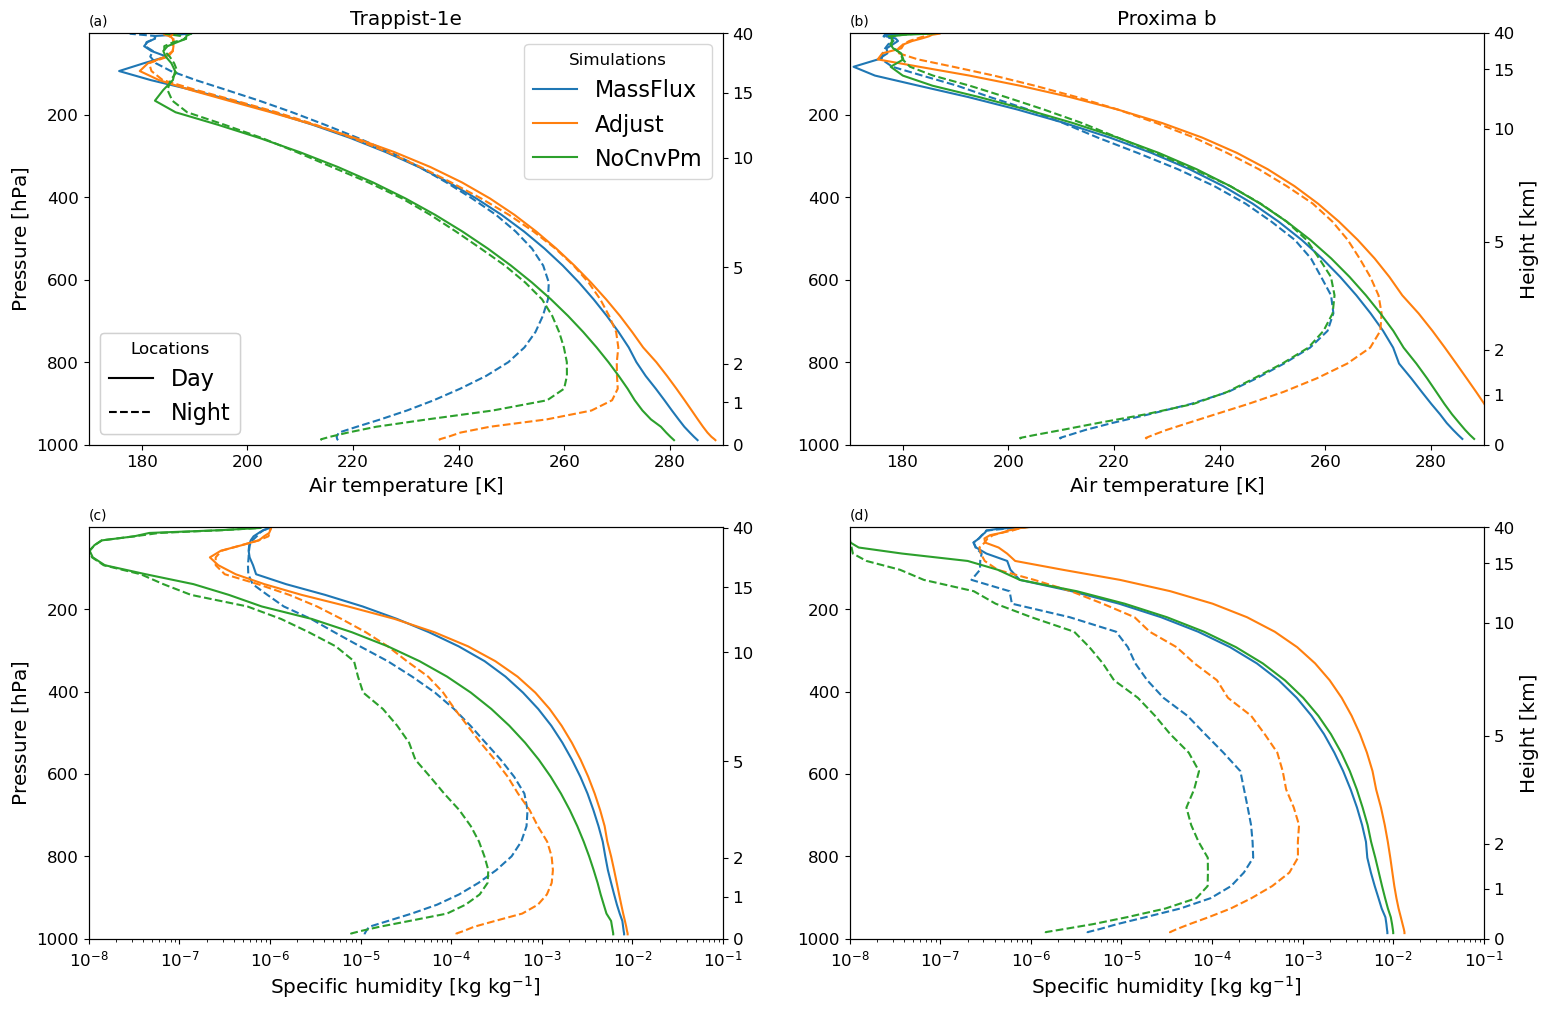

In [12]:
fig

And save it.

In [13]:
imgname = (
    mypaths.plotdir
    / f"{output_name_prefix}__vprof_daynight_pm{ddeg:02d}deg__{'_'.join(vrbls2plot.keys())}.png"
)

In [14]:
fig.savefig(imgname, dpi=200)
print(f"Saved to ../{imgname.relative_to(mypaths.topdir)}")

Saved to ../plots/trap1e_proxb__grcs_llcs_all_rain_acoff__vprof_daynight_pm01deg__temp_shum.png
